# SETUP

In [1]:
# !conda env create -f environment.yaml
# !conda activate ldm

In [2]:
import omegaconf

In [3]:
with open('configs/stable-diffusion/v1-inference.yaml') as fd:
    config = omegaconf.OmegaConf.load(fd)

In [4]:
config['model']['target']

'ldm.models.diffusion.ddpm.LatentDiffusion'

In [5]:
config['model']['params']

{'linear_start': 0.00085, 'linear_end': 0.012, 'num_timesteps_cond': 1, 'log_every_t': 200, 'timesteps': 1000, 'first_stage_key': 'jpg', 'cond_stage_key': 'txt', 'image_size': 64, 'channels': 4, 'cond_stage_trainable': False, 'conditioning_key': 'crossattn', 'monitor': 'val/loss_simple_ema', 'scale_factor': 0.18215, 'use_ema': False, 'scheduler_config': {'target': 'ldm.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}, 'unet_config': {'target': 'ldm.modules.diffusionmodules.openaimodel.UNetModel', 'params': {'image_size': 32, 'in_channels': 4, 'out_channels': 4, 'model_channels': 320, 'attention_resolutions': [4, 2, 1], 'num_res_blocks': 2, 'channel_mult': [1, 2, 4, 4], 'num_heads': 8, 'use_spatial_transformer': True, 'transformer_depth': 1, 'context_dim': 768, 'use_checkpoint': True, 'legacy': False}}, 'first_stage_config': {'target': 'ldm.models.autoencoder.AutoencoderKL', 

In [6]:
import importlib
def get_class_from_str(objname):
    module, cls = objname.rsplit(".", 1)
    return getattr(importlib.import_module(module, package=None), cls)

In [7]:
ModelClass = get_class_from_str(config['model']['target'])

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = ModelClass(**config['model']['params'])

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.mlp.fc2.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.18.self_attn.v_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.22.self_attn.q_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_mo

In [9]:
!ls /mnt/efs/hf/cache/stable-diffusion-hd-2022DEC10-6076.pth

/mnt/efs/hf/cache/stable-diffusion-hd-2022DEC10-6076.pth


In [10]:
import os
import torch

cache_dir = '/mnt/efs/hf/cache'
ckpt = os.path.join(cache_dir, 'stable-diffusion-hd-2022DEC10-6076.pth')
pl_sd = torch.load(ckpt, map_location="cpu")

In [11]:
state_dict = pl_sd["state_dict"]
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2'], unexpected_keys=[])

In [12]:
model.cond_stage_model is None

False

In [13]:
model.clip_denoised

False

In [14]:
image_size = model.image_size
channels = model.channels
image_size, channels

(64, 4)

In [15]:
model.num_timesteps

1000

In [16]:
model.betas.shape

torch.Size([1000])

In [17]:
import ldm
ldm.models.diffusion.__file__

'/home/ec2-user/workspace/stable-diffusion/ldm/models/diffusion/__init__.py'

In [18]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
import torch
from torchvision import transforms as tfms

def pil_to_latent(autoencoder, input_im, device):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        gaussian_distribution = autoencoder.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(device)*2-1) # Note scaling
    return 0.18215 * gaussian_distribution.sample()

def latents_to_pil(autoencoder, latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = autoencoder.decode(latents)
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [20]:
model = model.cuda()
model = model.eval()
model

LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequential(
              (0):

In [21]:
from PIL import Image
input_im = Image.open('./assets/rick.jpeg')

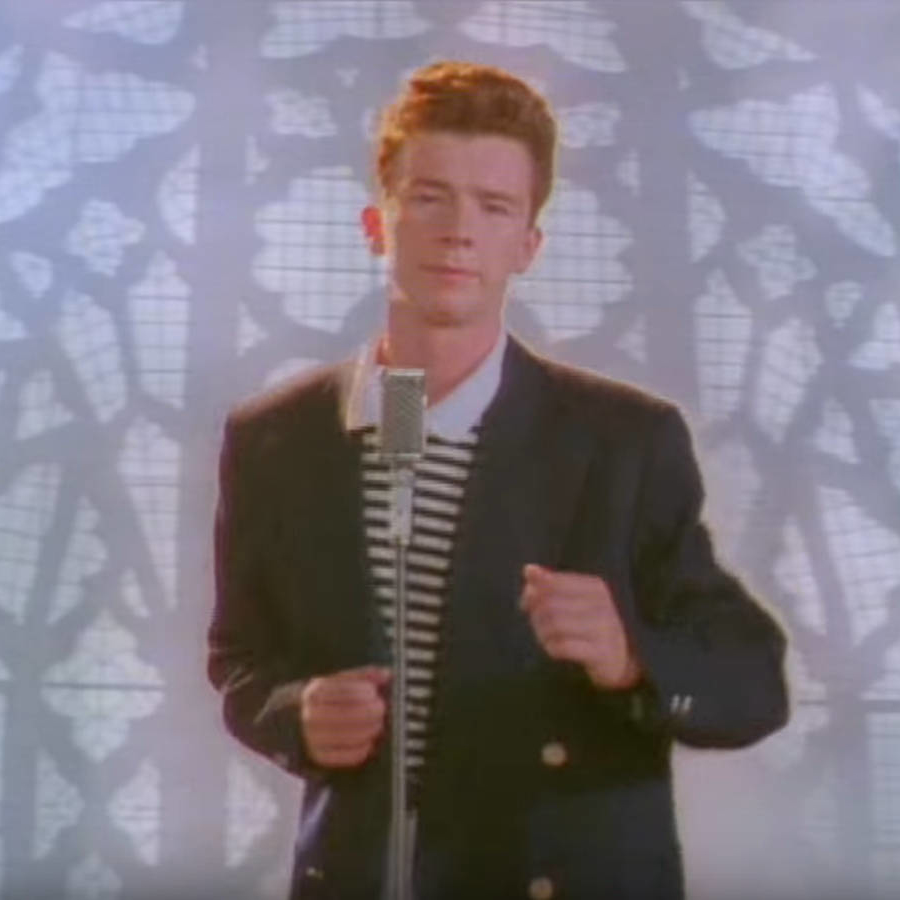

In [22]:
input_im

In [23]:
latent = pil_to_latent(model.first_stage_model, input_im, device=torch_device)

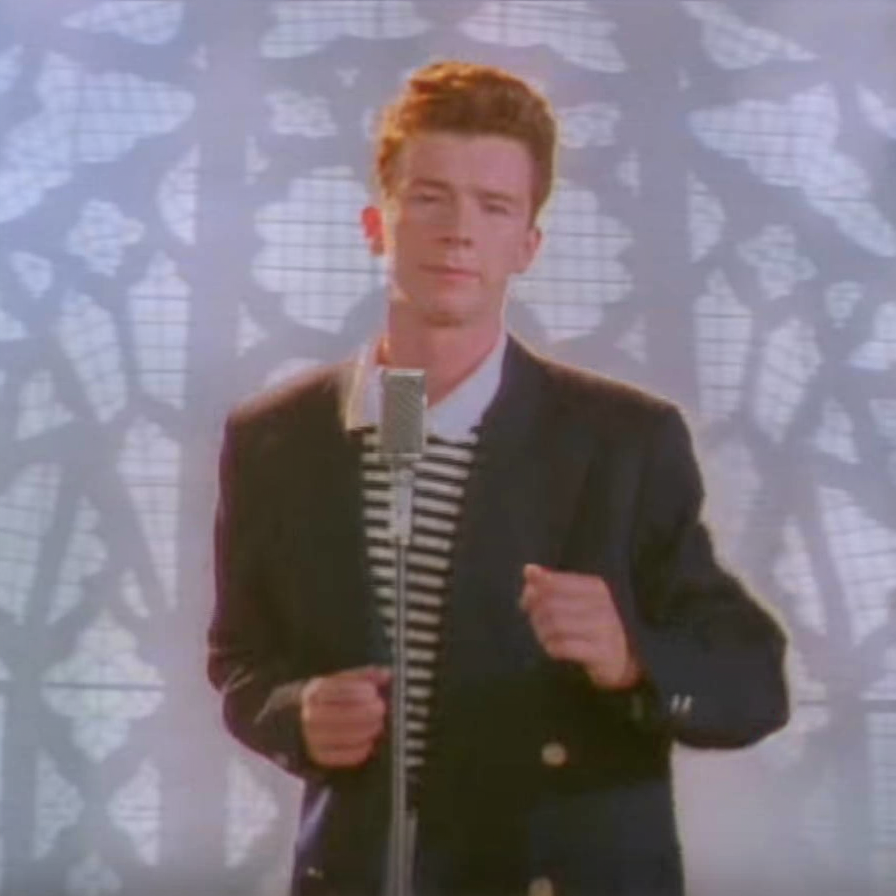

In [24]:
latents_to_pil(model.first_stage_model, latent)[0]

In [25]:
tokenizer = model.cond_stage_model.tokenizer
text_encoder = model.cond_stage_model.transformer

In [34]:
def encode_text(text_encoder, text, max_length):
    batch_encoding = tokenizer(text, 
                               truncation=True, 
                               max_length=max_length, 
                               return_length=True,
                               return_overflowing_tokens=False, 
                               padding="max_length", 
                               return_tensors="pt")
    tokens = batch_encoding["input_ids"].to(text_encoder.device)
    outputs = text_encoder(input_ids=tokens)
    return outputs.last_hidden_state

In [35]:
text_embedding = encode_text(text_encoder, 'hello world', max_length=77)

In [36]:
text_embedding.shape

torch.Size([1, 77, 768])

In [37]:
# unet model
unet = model.model

In [38]:
unet.device

device(type='cuda', index=0)

In [39]:
text_embedding.shape

torch.Size([1, 77, 768])

In [31]:
# Some settings
prompt = "A watercolor painting of an otter with a gun"
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

In [89]:
SchedulerClass = get_class_from_str(config['model']['params']['scheduler_config']['target'])
scheduler = SchedulerClass(**config['model']['params']['scheduler_config']['params'])

In [92]:
height // 8

64

In [42]:
512 // 8

64

In [46]:
conditional_text = encode_text(text_encoder, prompt, max_length=77)
unconditional_text = encode_text(text_encoder, "", max_length=77)

# prep latents
latents = torch.randn(
  (batch_size, 4, height // 8, width // 8),
  generator=generator,
)

# predict the noise residual
latent_model_input = torch.cat([latents] * 2)

t = 0
t_tensor = torch.full((batch_size,), t, device=torch_device)

print('inputs')
print(conditional_text.shape)
print(t_tensor.shape)
print(latent_model_input.shape)

inputs
torch.Size([1, 77, 768])
torch.Size([1])
torch.Size([2, 4, 64, 64])


In [51]:
4 * 64 * 64 * 1

16384

In [49]:
77 * 768

59136

In [52]:
c_crossattn=[unconditional_text.to(torch_device), conditional_text.to(torch_device)]

In [55]:
torch.cat(c_crossattn, 1).shape

torch.Size([1, 154, 768])

In [ ]:
## Denoising Diffusion Probabilistic Model
## Denoising Diffusion Implicit Model

In [57]:
unet.diffusion_model

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 3), st

In [48]:
noise_pred = unet(latent_model_input.to(torch_device), 
                  t_tensor,
                  c_concat=None, 
                  c_crossattn=c_crossattn)

RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [16, 4096, 40]->[16, 4096, 1, 40] [8, 154, 40]->[8, 1, 154, 40]

In [80]:
from tqdm import tqdm_notebook as tqdm
device = model.betas.device

shape = (1, 3, 512, 512)
b = shape[0]
img = torch.randn(shape, device=device)
# intermediates = [img]
# for i in tqdm(reversed(range(0, model.num_timesteps)), desc='Sampling t', total=model.num_timesteps):
    # img = model.p_sample(img, 
    #                     torch.full((b, ), i, device=device, dtype=torch.long),
    #                     clip_denoised=model.clip_denoised)
model_mean, _, model_log_variance = model.p_mean_variance(x=img, 
                                                        t=0,
                                                        c=3, 
                                                        clip_denoised=False)

TypeError: expected Tensor as element 0 in argument 0, but got int